# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block14_sepconv1', 'block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7808 - accuracy: 0.7423

947/947 [==============================] - 2928s 3s/step - loss: 0.7808 - accuracy: 0.7423 - val_loss: 0.8500 - val_accuracy: 0.7575
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.7699

947/947 [==============================] - 2828s 3s/step - loss: 0.6625 - accuracy: 0.7699 - val_loss: 0.7126 - val_accuracy: 0.7654
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.7855

947/947 [==============================] - 2826s 3s/step - loss: 0.6093 - accuracy: 0.7855 - val_loss: 0.6739 - val_accuracy: 0.7558
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.7961

947/947 [==============================] - 2825s 3s/step - loss: 0.5779 - accuracy: 0.7961 - val_loss: 0.5768 - val_accuracy: 0.7942
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5444 - accuracy: 0.8103

947/947 [==============================] - 2825s 3s/step - loss: 0.5444 - accuracy: 0.8103 - val_loss: 0.5249 - val_accuracy: 0.8124
Epoch 6/200
947/947 [==============================] - 3060s 3s/step - loss: 0.5214 - accuracy: 0.8164 - val_loss: 0.5440 - val_accuracy: 0.8124
Epoch 7/200
947/947 [==============================] - 3256s 3s/step - loss: 0.4980 - accuracy: 0.8226 - val_loss: 0.7097 - val_accuracy: 0.7564
Epoch 8/200
947/947 [==============================] - 3118s 3s/step - loss: 0.4784 - accuracy: 0.8342 - val_loss: 0.5535 - val_accuracy: 0.8147
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8349

947/947 [==============================] - 3167s 3s/step - loss: 0.4620 - accuracy: 0.8349 - val_loss: 0.4853 - val_accuracy: 0.8283
Epoch 10/200
947/947 [==============================] - 3090s 3s/step - loss: 0.4374 - accuracy: 0.8437 - val_loss: 0.5388 - val_accuracy: 0.8148
Epoch 11/200
947/947 [==============================] - 3125s 3s/step - loss: 0.4305 - accuracy: 0.8463 - val_loss: 0.6440 - val_accuracy: 0.7914
Epoch 12/200
947/947 [==============================] - 2938s 3s/step - loss: 0.4111 - accuracy: 0.8542 - val_loss: 0.5884 - val_accuracy: 0.8188
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8565

947/947 [==============================] - 2854s 3s/step - loss: 0.3947 - accuracy: 0.8565 - val_loss: 0.4720 - val_accuracy: 0.8362
Epoch 14/200
947/947 [==============================] - 2742s 3s/step - loss: 0.3762 - accuracy: 0.8651 - val_loss: 0.5334 - val_accuracy: 0.8209
Epoch 15/200
947/947 [==============================] - 2806s 3s/step - loss: 0.3629 - accuracy: 0.8690 - val_loss: 0.5449 - val_accuracy: 0.8157
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.3547 - accuracy: 0.8719

947/947 [==============================] - 2998s 3s/step - loss: 0.3547 - accuracy: 0.8719 - val_loss: 0.4638 - val_accuracy: 0.8402
Epoch 17/200
947/947 [==============================] - 3457s 4s/step - loss: 0.3349 - accuracy: 0.8787 - val_loss: 0.5395 - val_accuracy: 0.8227
Epoch 18/200
947/947 [==============================] - 3269s 3s/step - loss: 0.3227 - accuracy: 0.8835 - val_loss: 0.4942 - val_accuracy: 0.8350
Epoch 19/200
947/947 [==============================] - 3357s 4s/step - loss: 0.3114 - accuracy: 0.8852 - val_loss: 0.4878 - val_accuracy: 0.8527
Epoch 20/200
947/947 [==============================] - 3257s 3s/step - loss: 0.2995 - accuracy: 0.8911 - val_loss: 0.5122 - val_accuracy: 0.8290
Epoch 21/200
947/947 [==============================] - 3101s 3s/step - loss: 0.2857 - accuracy: 0.8964 - val_loss: 0.5227 - val_accuracy: 0.8344
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9009

947/947 [==============================] - 2868s 3s/step - loss: 0.2709 - accuracy: 0.9009 - val_loss: 0.4530 - val_accuracy: 0.8538
Epoch 23/200
947/947 [==============================] - 2793s 3s/step - loss: 0.2630 - accuracy: 0.9038 - val_loss: 0.4948 - val_accuracy: 0.8453
Epoch 24/200
947/947 [==============================] - 3040s 3s/step - loss: 0.2511 - accuracy: 0.9079 - val_loss: 0.4876 - val_accuracy: 0.8449
Epoch 25/200
947/947 [==============================] - 3251s 3s/step - loss: 0.2430 - accuracy: 0.9132 - val_loss: 0.5461 - val_accuracy: 0.8365
Epoch 26/200
947/947 [==============================] - 3266s 3s/step - loss: 0.2314 - accuracy: 0.9155 - val_loss: 0.4563 - val_accuracy: 0.8575
Epoch 27/200
947/947 [==============================] - 3222s 3s/step - loss: 0.2211 - accuracy: 0.9190 - val_loss: 0.4740 - val_accuracy: 0.8518
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9223

947/947 [==============================] - 3326s 4s/step - loss: 0.2154 - accuracy: 0.9223 - val_loss: 0.4377 - val_accuracy: 0.8613
Epoch 29/200
947/947 [==============================] - 2943s 3s/step - loss: 0.2056 - accuracy: 0.9247 - val_loss: 0.5051 - val_accuracy: 0.8461
Epoch 30/200
947/947 [==============================] - 2777s 3s/step - loss: 0.1965 - accuracy: 0.9288 - val_loss: 0.5269 - val_accuracy: 0.8488
Epoch 31/200
947/947 [==============================] - 2993s 3s/step - loss: 0.1888 - accuracy: 0.9307 - val_loss: 0.5682 - val_accuracy: 0.8444
Epoch 32/200
947/947 [==============================] - 2796s 3s/step - loss: 0.1781 - accuracy: 0.9351 - val_loss: 0.4970 - val_accuracy: 0.8600
Epoch 33/200
947/947 [==============================] - 3182s 3s/step - loss: 0.1723 - accuracy: 0.9366 - val_loss: 0.6027 - val_accuracy: 0.8394
Epoch 34/200
947/947 [==============================] - 3532s 4s/step - loss: 0.1676 - accuracy: 0.9394 - val_loss: 0.5578 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 306s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9799952363577394,
 'basal cell carcinoma': 0.9867722308673648,
 'dermatofibroma': 0.9324863119472132,
 'melanoma': 0.9368473478503629,
 'nevus': 0.9685624259062833,
 'pigmented benign keratosis': 0.9869709791889681,
 'seborrheic keratosis': 0.9651190378953183,
 'solar lentigo': 0.928301059845406,
 'squamous cell carcinoma': 0.9677037077396682,
 'vascular lesion': 0.9996426018584703}

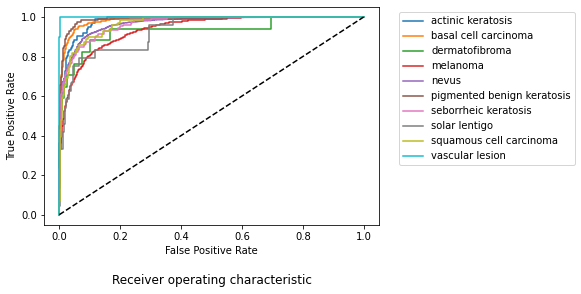

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

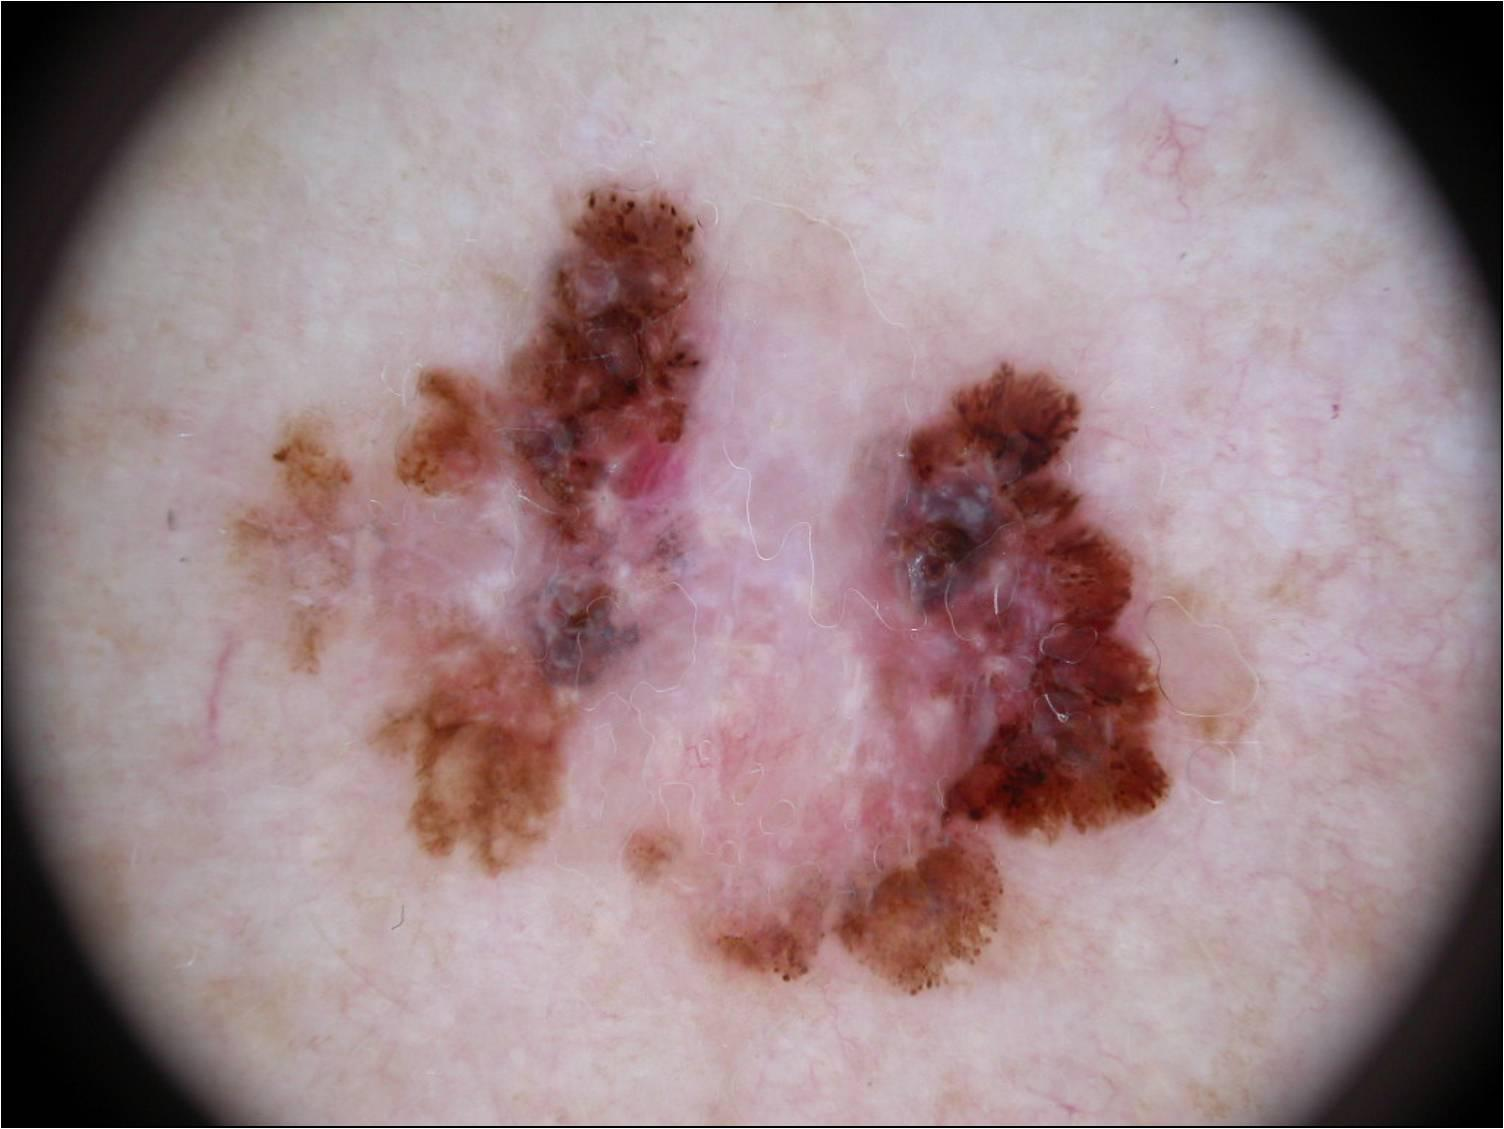

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

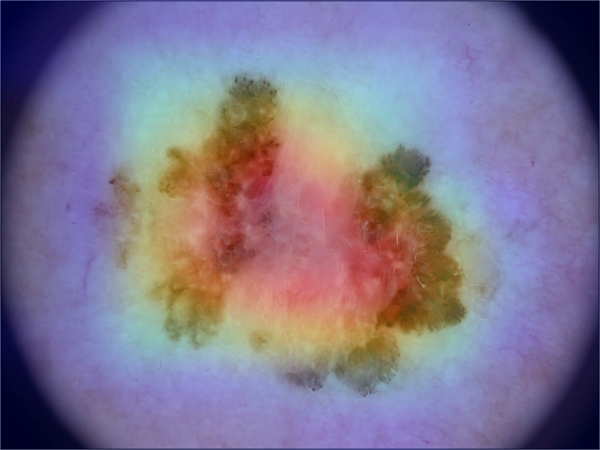

In [23]:
display_gradcam(melanoma_im_path, heatmap)